## Understanding Representation Learning with Deep Convolutionsl Generative Adversarial Networks

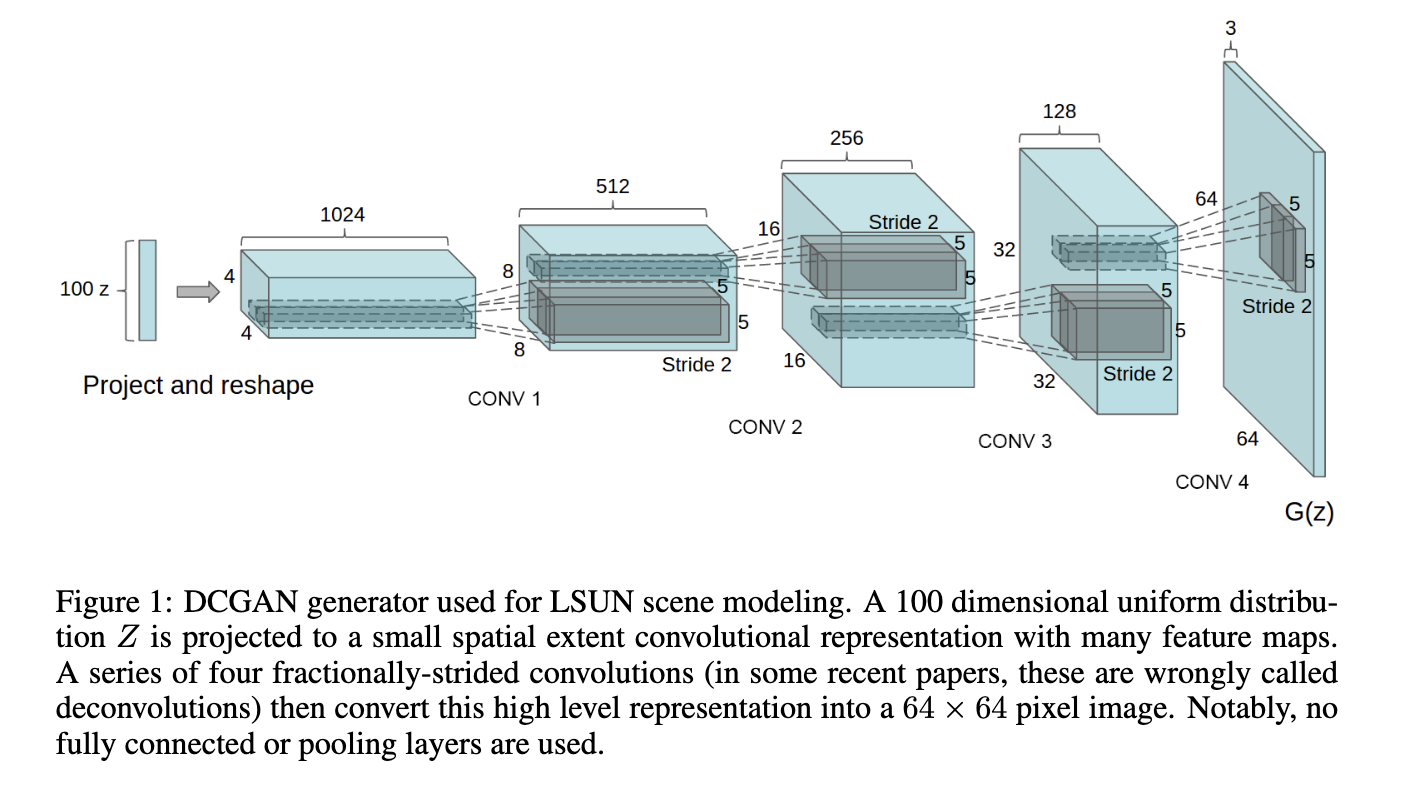

### Architecture guidline for stable Deep Convolution GANs
- Replace any pooling layers with strided convolutions (discriminators) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator
- Remove fully connected hidden layers for deeper architectures
- Use ReLactivation in generator for all layers except the output which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            # Input: N x C x 64 x 64
            nn.Conv2d(
                img_channels, features_d, kernel_size=4, stride=2, padding=1
            ), # N x featured_d x 32 x 32
            nn.LeakyReLU(0.2), 
            self._block(features_d, features_d*2, 4, 2, 1), # 16x16
            self._block(features_d*2, features_d*4, 4, 2, 1), # 8x8
            self._block(features_d*4, features_d*8, 4, 2, 1), # 4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size, 
                stride, 
                padding, 
                bias=False # unnecessary
            ), 
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # N x f_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16 x 16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32 x 32
            nn.ConvTranspose2d(features_g*2, img_channels, 4, 2, 1), # 64 x 64
            nn.Tanh(), # [-1, 1] since, the images are normalized in this range
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                kernel_size, 
                stride, 
                padding, 
                bias=False
            ), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
model = Generator(32, 32, 32)
for m in model.modules():
    print(m)
    print('\n\n')

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(64, 32, kernel

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success!")

test()

Success!
